### predicting in this project 
1. Tax Liability 

In [182]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,StackingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,mean_absolute_error,mean_squared_error,r2_score,accuracy_score
from sklearn.svm import SVR
from sklearn.linear_model import Ridge,Lasso
import numpy as np


## Load the Data

In [183]:
df = pd.read_csv("Residence_tax.csv")

In [184]:
df.head()

,Tax Year,Resident Type,Place of Residence,Country,State,County,Income Class,Disclosure,Number of All Returns,NY AGI of All Returns (in thousands) *,Deductions of All Returns (in thousands),Dependent Exemptions of All Returns (in thousands),Taxable Income of All Returns (in thousands),Tax Before Credits of All Returns (in thousands),Tax Liability of All Returns (in thousands) **,Place of Residence Sort Order,Income Class Sort Order
0,2012,Full-Year Nonresident,Ireland,Ireland,Not Applicable,Not Applicable,"40,000 - 49,999",d/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205,6
1,2012,Full-Year Nonresident,Ireland,Ireland,Not Applicable,Not Applicable,"50,000 - 59,999",d/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205,7
2,2012,Full-Year Nonresident,Ireland,Ireland,Not Applicable,Not Applicable,"60,000 - 74,999",d/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205,8
3,2012,Full-Year Nonresident,A.P.O./F.P.O,A.P.O./F.P.O,All,All,"Under 5,000",NaN,632.0,-2644.0,105.0,0.0,2.0,0.0,0.0,150,1
4,2012,Full-Year Nonresident,A.P.O./F.P.O,A.P.O./F.P.O,All,All,"5,000 - 9,999",NaN,58.0,433.0,255.0,0.0,21.0,1.0,1.0,150,2


In [185]:
df.columns

Index(['Tax Year', 'Resident Type', 'Place of Residence', 'Country', 'State',
       'County', 'Income Class', 'Disclosure', 'Number of All Returns',
       'NY AGI of All Returns (in thousands) *',
       'Deductions of All Returns (in thousands)',
       'Dependent Exemptions of All Returns (in thousands)',
       'Taxable Income of All Returns (in thousands)',
       'Tax Before Credits of All Returns (in thousands)',
       'Tax Liability of All Returns (in thousands) **',
       'Place of Residence Sort Order', 'Income Class Sort Order'],
      dtype='object')

### Handle Missing Values

In [186]:
df.isnull().sum()

Tax Year                                                  0
Resident Type                                             0
Place of Residence                                        0
Country                                                   0
State                                                     0
County                                                    0
Income Class                                              0
Disclosure                                            23439
Number of All Returns                                   296
NY AGI of All Returns (in thousands) *                  296
Deductions of All Returns (in thousands)                296
Dependent Exemptions of All Returns (in thousands)      296
Taxable Income of All Returns (in thousands)            296
Tax Before Credits of All Returns (in thousands)        296
Tax Liability of All Returns (in thousands) **          296
Place of Residence Sort Order                             0
Income Class Sort Order                 

In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23735 entries, 0 to 23734
Data columns (total 17 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Tax Year                                            23735 non-null  int64  
 1   Resident Type                                       23735 non-null  object 
 2   Place of Residence                                  23735 non-null  object 
 3   Country                                             23735 non-null  object 
 4   State                                               23735 non-null  object 
 5   County                                              23735 non-null  object 
 6   Income Class                                        23735 non-null  object 
 7   Disclosure                                          296 non-null    object 
 8   Number of All Returns                               23439 non-null  float64


#### We drop the "Disclosure" column because there more than 70% data is missing and for other columns we drop the rows of missing values . 

In [188]:
df.drop('Disclosure' , inplace = True , axis = 1)
df.dropna(axis = 0 , inplace = True)

In [189]:
df.shape

(23439, 16)

### Formatting the data Where columns having random values. 


In [190]:
format_data = [
    'All Other Countries +++', 'Residence Unknown ++++',
    'Grand Total, Full-Year Nonresident', 'Grand Total, Part-Year Resident',
    'All Other States', 'NYS Unclassified +', 'Residence Unknown ++',
    'All', 'Not Applicable', 'All - Excluding New Nork',
    'All Other States', 'All Other Countries +++',
    'Residence Unknown ++++', 'Total'
]


In [191]:
df.shape

(23439, 16)

In [192]:
place_to_drop = df[df["Place of Residence"].isin(format_data)].index
country_to_drop = df[df["Country"].isin(format_data)].index
state_to_drop = df[df["State"].isin(format_data)].index
income_to_drop = df[df["Income Class"].isin(format_data)].index

all_rows_to_drop = (
    place_to_drop
    .union(country_to_drop)
    .union(state_to_drop)
    .union(income_to_drop)
)

# Drop ONCE
df.drop(all_rows_to_drop , inplace=True)

In [193]:
df.shape

(19136, 16)

In [194]:
df.shape

(19136, 16)

County Column having higher number of random values . So , we will replace with "Unknown" .

In [195]:
county_to_drop = df[df['County'].isin(format_data)].index

In [196]:
df['County'] = df['County'].replace(format_data , 'Unknown')

In [197]:

for i in columns_names :
    print(f"{i} : {df[i].isin(format_data).sum()}")


Place of Residence : 0
Country : 0
State : 0
County : 0
Income Class : 0


In [198]:
df.describe()

,Tax Year,Number of All Returns,NY AGI of All Returns (in thousands) *,Deductions of All Returns (in thousands),Dependent Exemptions of All Returns (in thousands),Taxable Income of All Returns (in thousands),Tax Before Credits of All Returns (in thousands),Tax Liability of All Returns (in thousands) **,Place of Residence Sort Order,Income Class Sort Order
count,19136.000000,1.913600e+04,1.913600e+04,1.913600e+04,19136.000000,1.913600e+04,1.913600e+04,1.913600e+04,19136.000000,19136.000000
mean,2007.167956,1.463579e+04,1.071581e+06,1.789528e+05,8108.414298,8.754314e+05,5.904082e+04,4.551925e+04,66.732912,6.561141
std,4.611798,8.020389e+04,7.298601e+06,9.343613e+05,46651.038935,6.622207e+06,4.893662e+05,4.479119e+05,47.274468,3.537004
min,1999.000000,1.000000e+01,-1.262669e+07,7.000000e+00,0.000000,0.000000e+00,0.000000e+00,-4.674790e+05,1.000000,1.000000
25%,2003.000000,2.260000e+02,1.169025e+04,3.227500e+03,47.000000,4.881750e+03,2.390000e+02,2.700000e+01,26.750000,4.000000
50%,2008.000000,1.594500e+03,7.017700e+04,1.855300e+04,588.000000,4.456100e+04,2.357000e+03,1.114000e+03,51.500000,7.000000
75%,2011.000000,4.932250e+03,2.459650e+05,5.536400e+04,2481.250000,1.693080e+05,9.573750e+03,6.314250e+03,116.000000,10.000000
max,2014.000000,1.372544e+06,2.382972e+08,1.962783e+07,904387.000000,2.265283e+08,1.826171e+07,1.708919e+07,149.000000,13.000000


# Outlier Detection 

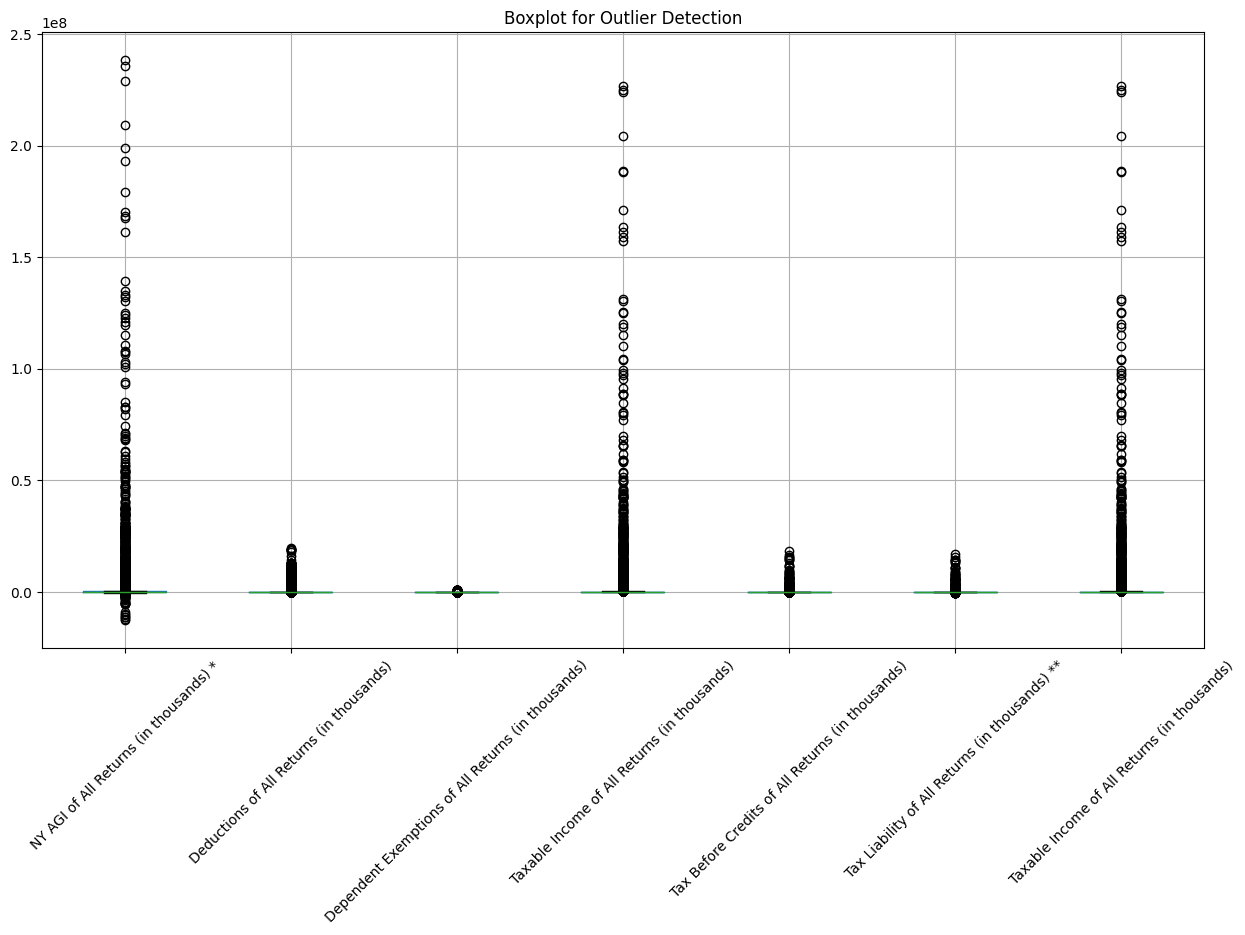

In [199]:
numeric_cols = [
    'NY AGI of All Returns (in thousands) *',
    'Deductions of All Returns (in thousands)',
    'Dependent Exemptions of All Returns (in thousands)',
    'Taxable Income of All Returns (in thousands)',
    'Tax Before Credits of All Returns (in thousands)',
    'Tax Liability of All Returns (in thousands) **',
    'Taxable Income of All Returns (in thousands)',
]

plt.figure(figsize=(15, 8))
df[numeric_cols].boxplot()
plt.title("Boxplot for Outlier Detection")
plt.xticks(rotation=45)
plt.show()

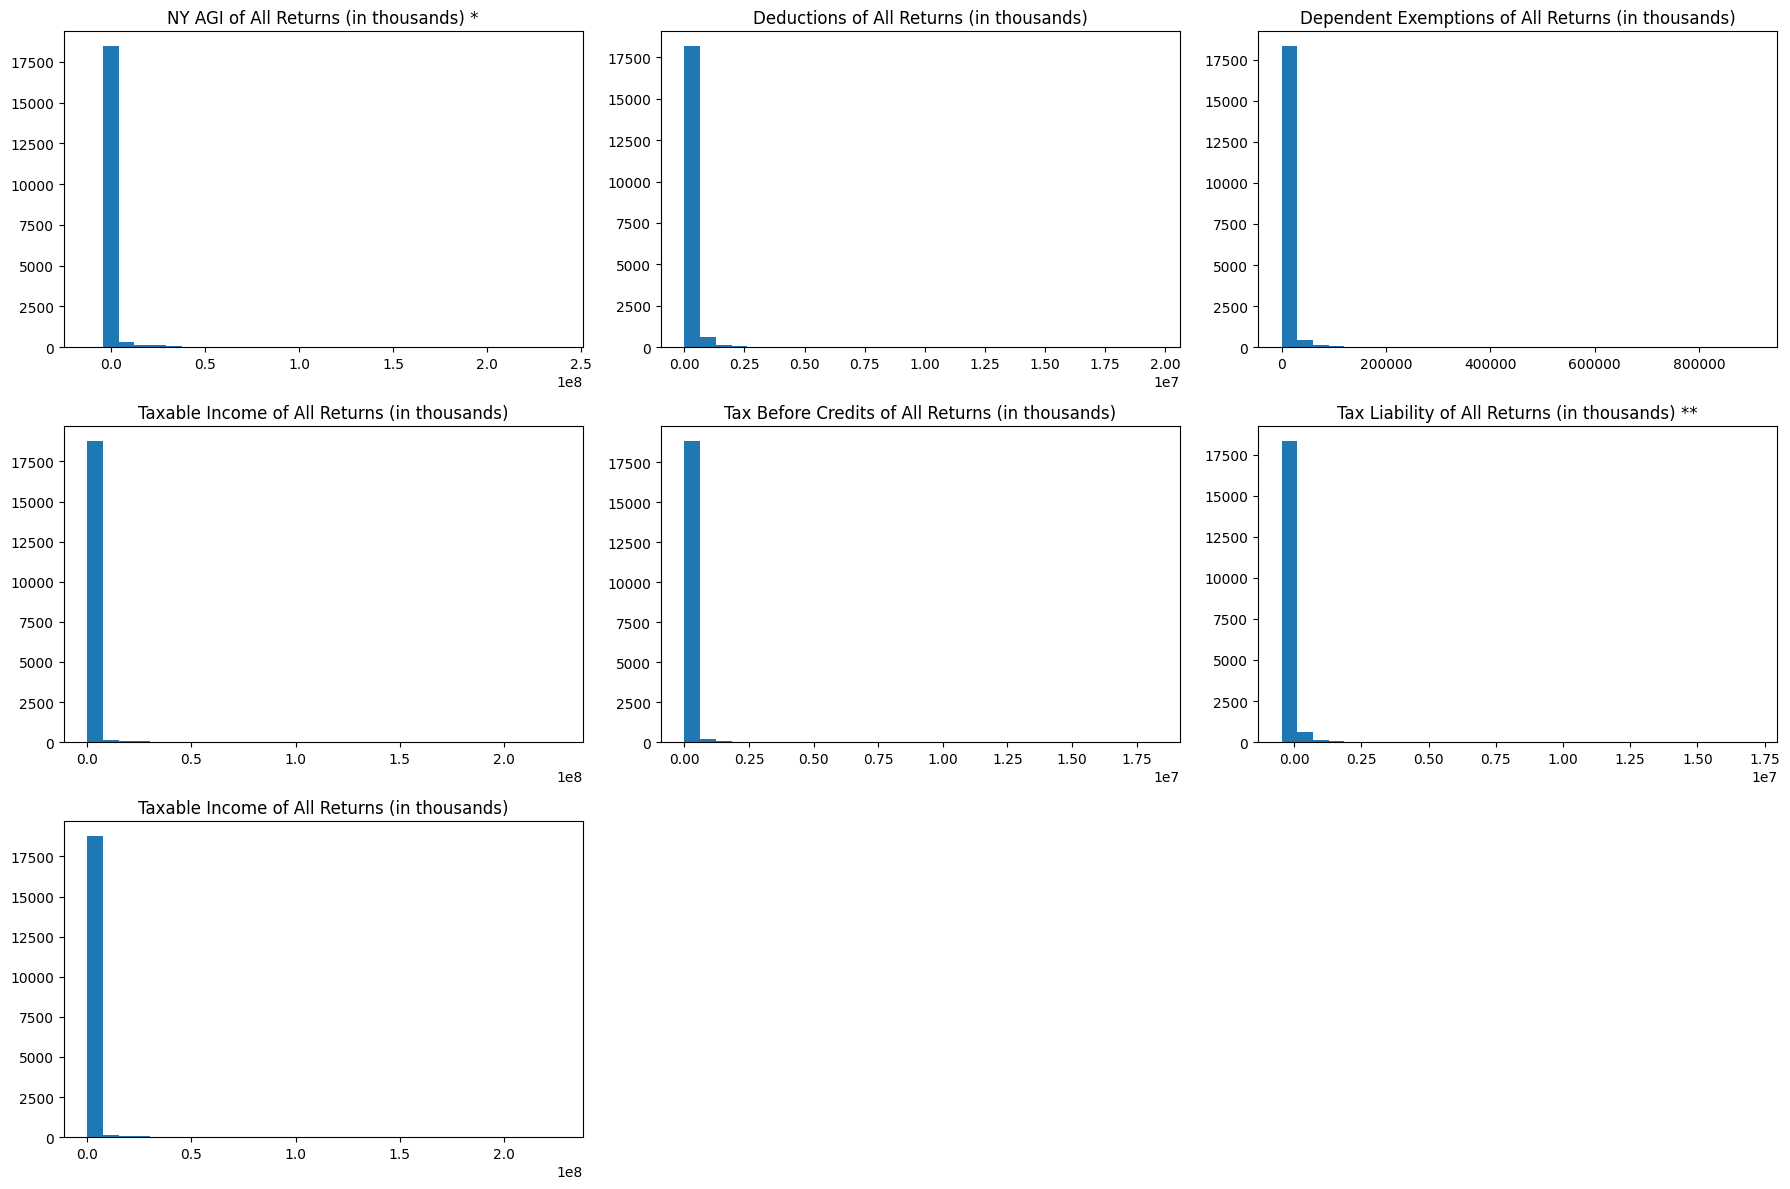

In [200]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 12))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)  
    plt.hist(df[col].dropna(), bins=30)
    plt.title(col)
    plt.tight_layout()

plt.show()


log transforming the data  as it is a financial dataset it is heavily squwed data 

In [201]:
df_transformed=df.copy()
df_transformed[['NY AGI of All Returns (in thousands) *','Deductions of All Returns (in thousands)','Dependent Exemptions of All Returns (in thousands)','Taxable Income of All Returns (in thousands)','Tax Before Credits of All Returns (in thousands)','Tax Liability of All Returns (in thousands) **']]=df_transformed[['NY AGI of All Returns (in thousands) *','Deductions of All Returns (in thousands)',
'Dependent Exemptions of All Returns (in thousands)','Taxable Income of All Returns (in thousands)','Tax Before Credits of All Returns (in thousands)','Tax Liability of All Returns (in thousands) **']].apply(np.log1p)


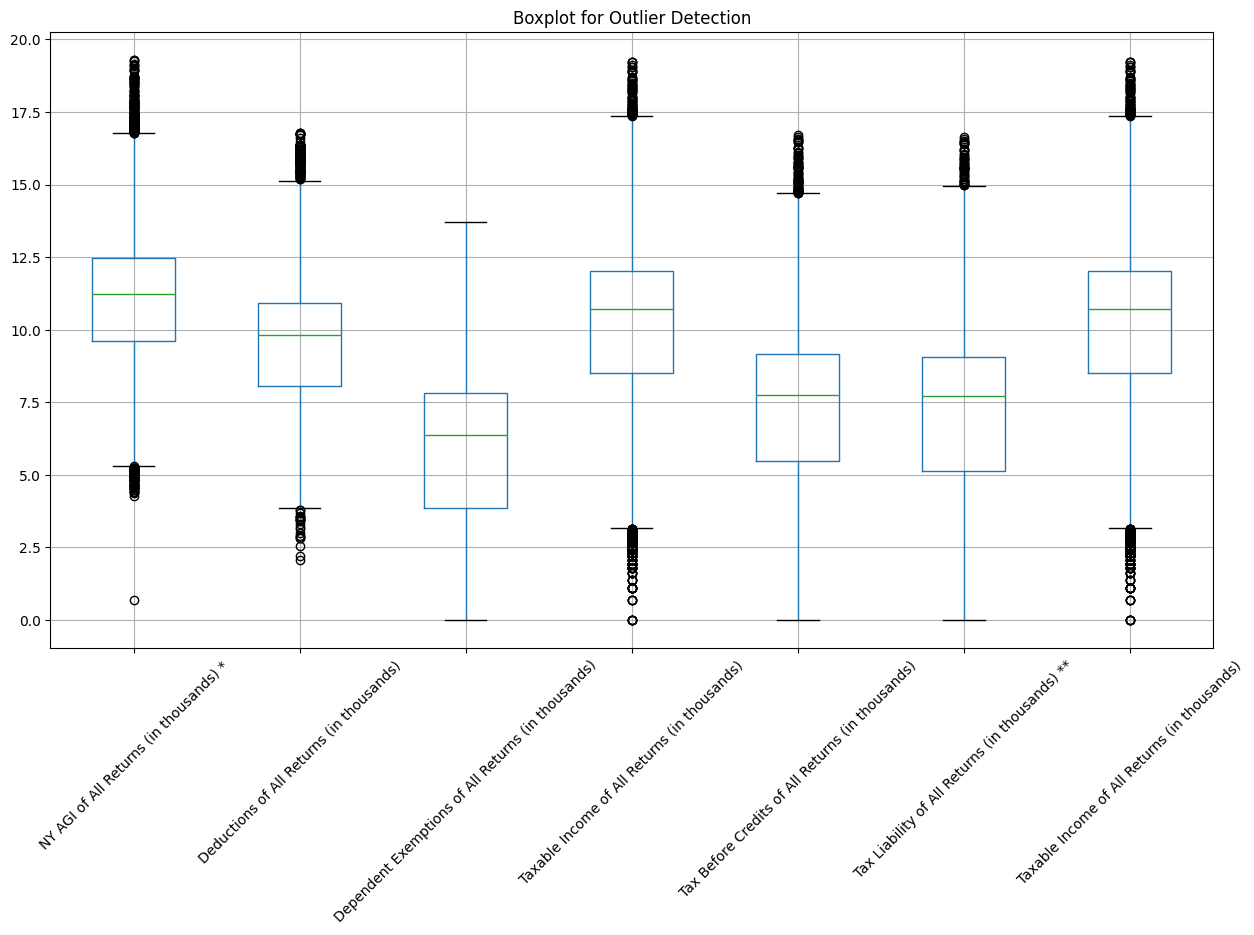

In [202]:
numeric_cols = [
    'NY AGI of All Returns (in thousands) *',
    'Deductions of All Returns (in thousands)',
    'Dependent Exemptions of All Returns (in thousands)',
    'Taxable Income of All Returns (in thousands)',
    'Tax Before Credits of All Returns (in thousands)',
    'Tax Liability of All Returns (in thousands) **',
    'Taxable Income of All Returns (in thousands)',
]

plt.figure(figsize=(15, 8))
df_transformed[numeric_cols].boxplot()
plt.title("Boxplot for Outlier Detection")
plt.xticks(rotation=45)
plt.show()

In [203]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df


In [168]:
numeric_cols = [
    'NY AGI of All Returns (in thousands) *',
    'Deductions of All Returns (in thousands)',
    'Dependent Exemptions of All Returns (in thousands)',
    'Taxable Income of All Returns (in thousands)',
    'Tax Before Credits of All Returns (in thousands)',
    'Tax Liability of All Returns (in thousands) **',
    'Taxable Income of All Returns (in thousands)',
]
df_transformed = remove_outliers(df_transformed, numeric_cols)



(15290, 16)

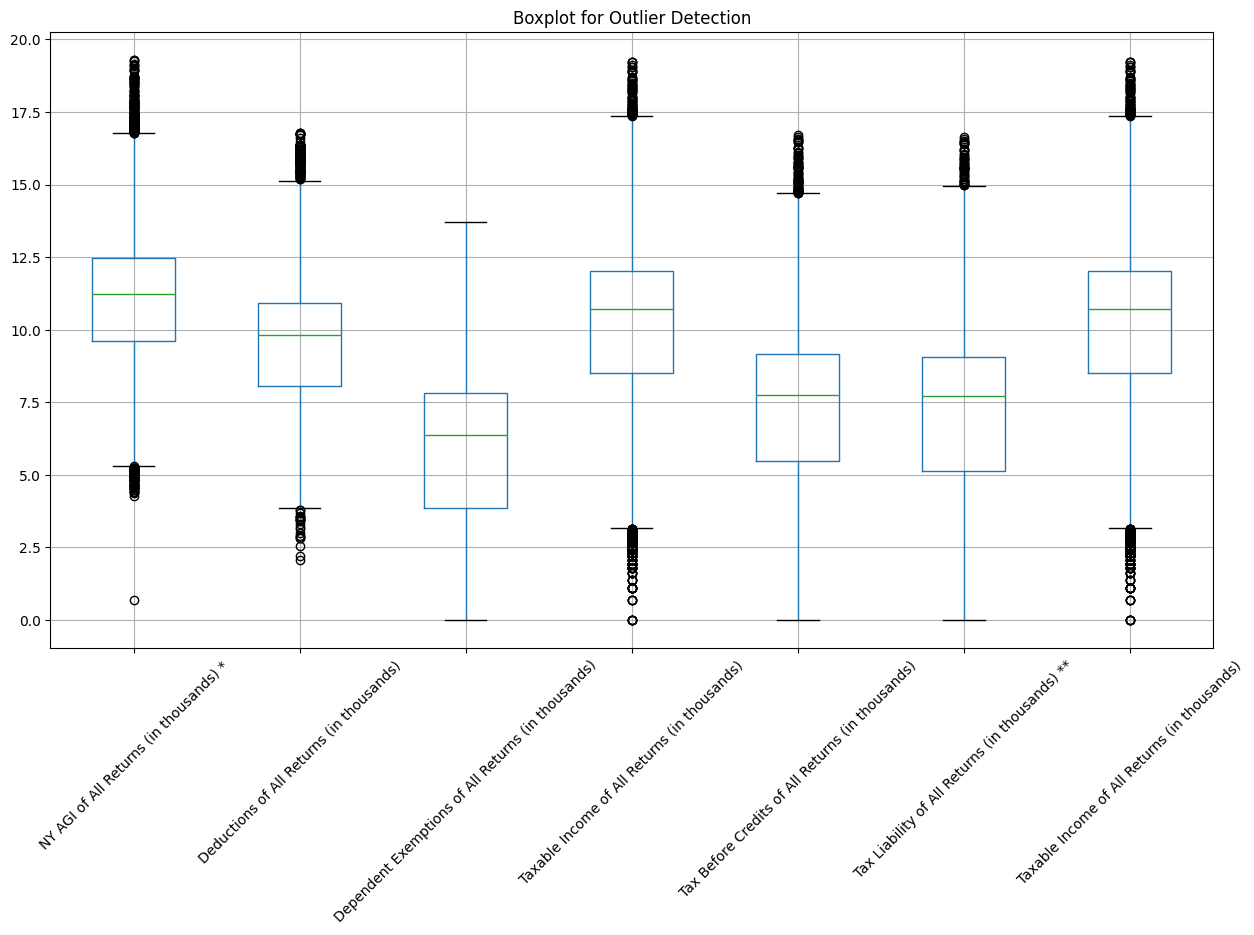

In [204]:
numeric_cols = [
    'NY AGI of All Returns (in thousands) *',
    'Deductions of All Returns (in thousands)',
    'Dependent Exemptions of All Returns (in thousands)',
    'Taxable Income of All Returns (in thousands)',
    'Tax Before Credits of All Returns (in thousands)',
    'Tax Liability of All Returns (in thousands) **',
    'Taxable Income of All Returns (in thousands)',
]

plt.figure(figsize=(15, 8))
df_transformed[numeric_cols].boxplot()
plt.title("Boxplot for Outlier Detection")
plt.xticks(rotation=45)
plt.show()

In [205]:
cols = [
    'NY AGI of All Returns (in thousands) *',
    'Deductions of All Returns (in thousands)',
    'Dependent Exemptions of All Returns (in thousands)',
    'Taxable Income of All Returns (in thousands)',
    'Tax Before Credits of All Returns (in thousands)',
    'Tax Liability of All Returns (in thousands) **'
]

df_transformed = df_transformed.copy()
df_transformed[cols] = np.expm1(df_transformed[cols])
df_transformed.dropna(inplace=True,axis=0)

In [206]:
df_transformed.replace([np.inf, -np.inf], np.nan, inplace=True)

splitting the dataset into train test split 

In [207]:
X=df_transformed.drop(['Tax Liability of All Returns (in thousands) **','County','Country','Income Class'], axis=1)
y=df_transformed['Tax Liability of All Returns (in thousands) **']

numeric_columns = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = X.select_dtypes(exclude=[np.number]).columns.tolist()

In [208]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

creating a preprocessing pipeline

In [209]:
from sklearn.impute import SimpleImputer


numeric_transformer=Pipeline(steps=[
    ('scaler', StandardScaler())
    
])

categorical_transformer=Pipeline(steps=[
  ('onhot',OneHotEncoder(handle_unknown='ignore'))
])
preprocessor=ColumnTransformer(
  transformers=[
    ('num',numeric_transformer,numeric_columns),
    ('cat',categorical_transformer,categorical_columns)
  ]
)

different model and its parameters stored in an dictionary

In [210]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


model_and_parameters={
  "Ridge":{
    "model":Ridge(),
    "params":{"model__alpha":[0.1,1.0,10.0]}
  },
  "Lasso":
  {
    "model":Lasso(),
    "params":{"model__alpha": [0.001, 0.01, 0.1, 1, 10]}
  },
  "Random Forest": {
        "model": RandomForestRegressor(),
        "params": {
            "model__n_estimators": [100, 200],
            "model__max_depth": [10, 15]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(),
        "params": {
            "model__learning_rate": [0.05, 0.1],
            "model__n_estimators": [100, 200]
        }
    },
    "SVR": {
        "model": SVR(),
        "params": {
            "model__C": [1, 10],
            "model__gamma": ["scale", "auto"]
        }
    }
}


In [ ]:
for model_names , model_param in model_and_parameters.items():
    print("\n\nMODEL NAME-->",model_names)
    pipeline=Pipeline(steps=[
      ('preprocessor',preprocessor),
      ('model',model_param['model'])
    ])

    grid_search=GridSearchCV(
        pipeline,
        model_param['params'],
        cv=5,
        scoring='neg_mean_squared_error',
        return_train_score=True
    )

    grid_search.fit(X_train,y_train)
    best_model=grid_search.best_estimator_
    best_params=grid_search.best_params_
    best_cv_rmse=np.sqrt(-grid_search.best_score_)
    print("Best parameter:",best_params)
    print("Best cv RMSE:",best_params)

    #train metrics
    train_predicted=best_model.predict(X_train)
    train_rmse=np.sqrt(mean_squared_error(y_train,train_predicted))
    train_r2=r2_score(y_train,train_predicted)
    #test metrics
    test_predicted=best_model.predict(X_test)
    test_rmse=np.sqrt(mean_squared_error(y_test,test_predicted))
    test_r2=r2_score(y_test,test_predicted)

    print("Perfomance:")
    print("\nTrain Result:")
    print("RMSE:",train_rmse)
    print("R2:",train_r2)

    print("\nTest Result:")
    print("RMSE:",test_rmse)
    print("R2:",test_r2)




MODEL NAME--> Ridge
Best parameter: {'model__alpha': 0.1}
Best cv RMSE: {'model__alpha': 0.1}
Perfomance:

Train Result:
RMSE: 38154.48733572245
R2: 0.9944783655108231

Test Result:
RMSE: 41494.1158532725
R2: 0.9888123781281011


MODEL NAME--> Lasso


c:\Users\akshp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8505568630234.881, tolerance: 171981883913.5264
  model = cd_fast.sparse_enet_coordinate_descent(
c:\Users\akshp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10166683744071.287, tolerance: 305020915840.7367
  model = cd_fast.sparse_enet_coordinate_descent(
c:\Users\akshp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11977302147257.678, tolerance: 298617185334.54504
  model = cd_fast.sparse_enet_coordinate_desc

Best parameter: {'model__alpha': 0.001}
Best cv RMSE: {'model__alpha': 0.001}
Perfomance:

Train Result:
RMSE: 45239.161440550044
R2: 0.9922374304920502

Test Result:
RMSE: 56947.712854310834
R2: 0.9789274388856919


MODEL NAME--> Random Forest
